In [448]:
from sklearn.svm import SVC
from HelperFunctions_ import classesInLabels
import numpy as np
import copy

def SeperateDataLabels(data,labels, seperation): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    #Check the labels and the seperation have the same number of classes or not 
    # Will remove the classes not in the seperation array. 
    
    if(len(seperation) == 2): 

        classesInSeperation = []

        for i in range(len(seperation)): 
            for j in range(len(seperation[i])): 
                if(not(seperation[i][j] in classesInSeperation)): 
                    classesInSeperation.append(seperation[i][j])

        classesInSeperation.sort()
        classesInSeperation = np.array(classesInSeperation)
        cIL = np.array(classesInLabels(labels))

        #Checks if the seperation and the labels have same amount of classes. If not return -1 ????
        if(not(np.array_equal(cIL, classesInSeperation))): 

            for i in range(len(cIL)): 
                if(not(cIL[i] in classesInSeperation)):
                    train_data = train_data[train_labels != cIL[i]]
                    train_labels = train_labels[train_labels != cIL[i]]

        if(len(classesInLabels(labels)) > 2):  #Remove this if not work
            for i in range(len(seperation)): 
                for j in range(len(seperation[i])):
                    if(seperation[i][j] != min(seperation[i])):
                        train_labels[train_labels == seperation[i][j]] = min(seperation[i])
        
        return train_data, train_labels
        
    else: 
        print("The seperation needs to be 2 in length. For 1v1 classification")
        return -1



def BranchDataLabels(data, labels, tree_branches): 

    """
    Takes in data and labes for the SVM Desion Tree. 
    Makes the labels for every branch 1v1 classes. 

    """

    if(len(tree_branches) > 0): 
        if(len(tree_branches[0]) == 2): 

            #Seperating the classes on the first branch of the data and the labels.
            data_and_labels_branches = {0 : SeperateDataLabels(data, labels, tree_branches[0])}
            
            for i in range(1,len(tree_branches)): 
                data_and_labels = []
                for j in range(len(tree_branches[i])): 
                    if(len(tree_branches[i][j]) == 2):
                            data_and_labels.append(SeperateDataLabels(data,labels,tree_branches[i][j]))
                    else: 
                        data_and_labels.append([])
                data_and_labels_branches[i] = data_and_labels

            return data_and_labels_branches
        
        else: 
            return -1


def SvmBranchModelTrain(data_and_labels_branches): 

    svm_branch_models = {}

    svm = SVC()
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = SVC()
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models[i] = svm_models

    return svm_branch_models


def SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models): 

    svm_branch_models_ = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models_[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = copy.deepcopy(svm_branch_models[i][j]) 
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models_[i] = svm_models

    return svm_branch_models_

"""
def SvmBranchModelPredict(data_and_labels_branches, svm_branch_models): 
    predicted_branch_labels = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    yout = svm.predict(train_data)
    predicted_branch_labels[0] = yout

    for i in range(1,len(data_and_labels_branches)): 
        predicted_labels = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = svm_branch_models[i][j]
                yout = svm.predict(train_data)
                predicted_labels.append(yout)
            else: 
                predicted_labels.append([])
        predicted_branch_labels[i] = predicted_labels

    return predicted_branch_labels

"""

def SvmBranchModelPredict(data, svm_branch_models, tree_branch, sub_data_return = 0): 
    
    test_data = copy.deepcopy(data)
    
    predicted_branch_labels = {}
    sub_data_branch = {}
    sub_data_sub_branch = []

    svm = svm_branch_models[0]
    yout = svm.predict(test_data)

    predicted_branch_labels[0] = yout
    sub_data_branch[0] = test_data

    sub_data_1 = test_data[yout == min(svm.classes_)]
    sub_data_2 = test_data[yout == max(svm.classes_)]

    if(min(svm.classes_) in tree_branch[0][0]): 
        sub_data_sub_branch.append(sub_data_1)
    else: 
        sub_data_sub_branch.append(sub_data_2)

    if(min(svm.classes_) in tree_branch[0][1]): 
        sub_data_sub_branch.append(sub_data_1)
    else: 
        sub_data_sub_branch.append(sub_data_2)

    sub_data_branch[1] = sub_data_sub_branch

    for i in range(1,len(svm_branch_models)):
        predicted_labels = []
        sub_data_sub_branch = []
        for j in range(len(svm_branch_models[i])): 
            if(svm_branch_models[i][j] != False):
                sub_data = sub_data_branch[i][j]
                svm = svm_branch_models[i][j]
              
                yout = svm.predict(sub_data)

                predicted_labels.append(yout)

                if(i <= len(svm_branch_models)):     
                    sub_data_1 = sub_data[yout == min(svm.classes_)]
                    sub_data_2 = sub_data[yout == max(svm.classes_)]

                    if(min(svm.classes_) in tree_branch[i][j][0]):
                        sub_data_sub_branch.append(sub_data_1)
                    else: 
                        sub_data_sub_branch.append(sub_data_2)
                     
                    if(min(svm.classes_) in tree_branch[i][j][1]):
                            sub_data_sub_branch.append(sub_data_1)
                    else: 
                        sub_data_sub_branch.append(sub_data_2)
            else: 
                predicted_labels.append([])

        predicted_branch_labels[i] = predicted_labels
        
        if((i-1) <= len(svm_branch_models)): 
            sub_data_branch[i+1] = sub_data_sub_branch

    if(sub_data_return == 0): 
        return predicted_branch_labels
    
    if(sub_data_return == 1): 
        return predicted_branch_labels, sub_data_branch



def combineLabels(predicted_labels, tree_branch): 

    pl = copy.deepcopy(predicted_labels)
    """
    Combine the result from the desion tree. Should be automated. 
    """
    #if(len(pl) == len(tree_branch)): 
    for i in range(len(pl)-2,0,-1): 
        for j in range(len(pl[i])): 
            for k in range(len(tree_branch[i][j])):
                for l in range(len(tree_branch[i][j][k])): 
                    if(tree_branch[i+1][j]):
                        if(tree_branch[i][j][k]):
                            try: 
                                if(min(tree_branch[i][j][k]) in tree_branch[i+1][j][l]):
                                    yout = pl[i][j] 
                                    yout_sub_class = pl[i+1][j]

                                    class_diff = np.abs(len(yout[yout == min(tree_branch[i][j][k])]) - len(yout_sub_class))
                                    for x in range(len(yout)): 
                                        if(yout[x] == min(tree_branch[i][j][k])):
                                            if(class_diff < len(yout_sub_class)):
                                                yout[x] = yout_sub_class[class_diff] 
                                                class_diff += 1
                                    pl[i][j] = yout
                                
                            except: 
                                None
    

    #Collecting the labels from the second branch layer to the first layer. 
    #Cobime the two second layers to the final labeling. 

    if(len(pl[1][0]) and not(len(pl[1][1]))): 
        yout_sub_1 = pl[1][0]
        yout_sub_2 = []
    
    elif(len(pl[1][1]) and not(len(pl[1][0]))):
        yout_sub_1 = []
        yout_sub_2 = pl[1][1]

    else: 
        yout_sub_1 = pl[1][0]
        yout_sub_2 = pl[1][1]

    yout = pl[0]

    if(yout_sub_1 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][1])]) - len(yout_sub_2))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][1]):
                if(class_diff < len(yout_sub_2)):
                    yout[x] = yout_sub_2[class_diff] 
                    class_diff += 1
        print(class_diff)

    elif(yout_sub_2 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][0])]) - len(yout_sub_1))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(class_diff < len(yout_sub_1)):
                    yout[x] = yout_sub_1[class_diff] 
                    class_diff += 1
        print(class_diff)

    else:
        count_sub_1 = 0 
        count_sub_2 = 0 
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(count_sub_1 < len(yout_sub_1)):
                    yout[x] = yout_sub_1[count_sub_1] 
                    count_sub_1 += 1
            if(yout[x] in tree_branch[0][1]):
                if(count_sub_2 < len(yout_sub_2)): 
                    yout[x] = yout_sub_2[count_sub_2] 
                    count_sub_2 += 1
    return yout



def RetrieveSubData(data,labels, sub_tree_branch): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    seperation = np.array(sub_tree_branch[0] + sub_tree_branch[1])

    classes = classesInLabels(labels)
    remove_classes = []

    for i in range(len(classesInLabels(labels))): 
        if(not(classes[i] in seperation)): 
            remove_classes.append(classes[i])
            

    for i in range(len(remove_classes)):
        if(remove_classes[i] in labels):
            train_data = train_data[train_labels != remove_classes[i]]
            train_labels = train_labels[train_labels != remove_classes[i]]
        
    return train_data, train_labels


def SvmDesionTree(data, labels, tree_branches, svm_branch_models = {}):
    import time

    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    data_and_labels_branches = BranchDataLabels(data, labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches)

    time_start = time.time()

    predicted_branch_labels = SvmBranchModelPredict(data, svm_branch_models, tree_branches)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    return predicted_label


def SvmDesionTreeTrain(train_data, train_labels, tree_branches, svm_branch_models = {}, sub_data = 0):
    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    data_and_labels_branches = BranchDataLabels(train_data, train_labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches) 

    if(sub_data):
        return svm_branch_models, data_and_labels_branches
    
    else: 
        return svm_branch_models
    

def SvmDesionTreePredict(test_data, svm_branch_models, tree_branches, sub_data = 0): 
    import time

    time_start = time.time()

    if(sub_data): 
        predicted_branch_labels, sub_data_branch = SvmBranchModelPredict(test_data, svm_branch_models, tree_branches, sub_data_return=sub_data)
    
    else: 
        predicted_branch_labels= SvmBranchModelPredict(test_data, svm_branch_models, tree_branches)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    if(sub_data): 
        return predicted_label, sub_data_branch, predicted_branch_labels   
    else: 
        return predicted_label




In [2]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
#from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels, SvmDesionTree2
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral
import tables as ta

In [10]:
#Loading correceted data 
indian_pines = sc.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines.mat")["indian_pines"]

# Loading pictures 
indian_pines_gt = sc.loadmat("../HyperSpectralData/Hyperspectral Remote Sensing Scenes/Indian_pines_gt.mat")["indian_pines_gt"]

In [15]:
print(len(indian_pines[0][0]))

220


In [540]:
# prepare data

X = indian_pines.transpose(0,2,1).reshape((-1,220))
y = indian_pines_gt.flatten()

X = preprocessing.scale(X, axis=0)                    # Normalization
#X = preprocessing.normalize(X, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1) 

In [541]:
#tb1 = {0: [[15,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,14]], 1 : [[[15],[16]],[[14],[1,2,3,4,5,6,7,8,9,10,11,12,13]]], 2 : [[],[[1,2,3,4,8,9,10,11,12,13],[5,6,7]]]}
#tb2 = {0 : [[1,2,3,4,8,9,10,11,12,13],[5,6,7]], 1 : [[[8],[1,2,3,4,9,10,11,12,13]],[[5],[6,7]]], 2: [[[10,11,12,13],[1,2,3,4,9]],[[6],[7]]]}
#tb3 = {0 : [[10,11,12,13],[1,2,3,4,9]], 1 : [[[13],[10,11,12]],[[1],[2,3,4,9]]], 2 : [[[10],[11,12]],[[2],[3,4,9]]], 3 : [[[11],[12]],[[4],[3,9]]], 4 : [[],[[3],[9]]]}

#iter = 1e3
#svm = SVC(kernel="linear", class_weight= "balanced", max_iter=iter)
#svm = LinearSVC(class_weight= "balanced", max_iter=iter)
#svmb1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) , 
#        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
#        2 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}

#svmb2 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) ,
#        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
#        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]}

#svmb3 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter), 
#        1 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
#        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
#        3 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
#        4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}




tb1 = {0: [[15,16],[1,2,3,4,5,6,7,8,9,10,11,12,13,14]], 1 : [[[15],[16]],[[14],[1,2,3,4,5,6,7,8,9,10,11,12,13]]]}
tb2 = {0 : [[1,2,3,4,8,9,10,11,12,13],[5,6,7]], 1 : [[[8],[1,2,3,4,9,10,11,12,13]],[[5],[6,7]]], 2 : [[],[[6],[7]]]}
tb3 = {0 : [[10,11,12,13],[1,2,3,4,9]], 1 : [[[13],[10,11,12]],[[1],[2,3,4,9]]], 2 : [[[10],[11,12]],[[2],[3,4,9]]], 3 : [[[11],[12]],[[4],[3,9]]], 4 : [[],[[3],[9]]]}

iter = 1e3
svm = SVC(kernel="linear", class_weight= "balanced", max_iter=iter)
svm = LinearSVC(class_weight= "balanced", max_iter=iter)
svmb1 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) , 
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb2 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter) ,
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
        2 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}

svmb3 = {0 : LinearSVC(class_weight= "balanced", max_iter=iter), 
        1 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)],
        3 : [LinearSVC(class_weight= "balanced", max_iter=iter),LinearSVC(class_weight= "balanced", max_iter=iter)],
        4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}




svm_tree_branches1, sub_data_branch1 = SvmDesionTreeTrain(X_train, y_train, tb1, svmb1, sub_data = 1)

sub_data2, sub_labels2 = RetrieveSubData(X_train, y_train, tb2[0])
svm_tree_branches2, sub_data_branch2 = SvmDesionTreeTrain(sub_data2, sub_labels2, tb2, svmb2, sub_data=1)

sub_data3, sub_labels3 = RetrieveSubData(X_train, y_train, tb3[0])
svm_tree_branches3, sub_data_branch3 = SvmDesionTreeTrain(sub_data3, sub_labels3, tb3, svmb3, sub_data=1)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear 

In [542]:
def classesSvmBranches(svm_tree_branch):
    cSB = [svm_tree_branch[0].classes_]
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].classes_)
        cSB.append(branch)
    
    return cSB

def SupportVectorsSvmBranches(svm_tree_branch):
    cSB = [svm_tree_branch[0].n_support_]
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].n_support_)
        cSB.append(branch)
    
    return cSB

def BranchAverageAccuracy(): 
    


SyntaxError: incomplete input (2803728567.py, line 24)

In [543]:
pl1, sd1, pbl1 = SvmDesionTreePredict(X, svm_tree_branches1, tb1, sub_data=1)

The prediction time is: 0.189 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:267: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:276: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [544]:
pl2, sd2, pbl2 = SvmDesionTreePredict(sd1[1][1], svm_tree_branches2, tb2, sub_data=1)

The prediction time is: 0.162 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:267: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:276: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [545]:
pl3, sd3, pbl3 = SvmDesionTreePredict(sd2[1][0], svm_tree_branches3, tb3, sub_data=1)

The prediction time is: 0.189 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:267: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:276: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [546]:
predicted_label3 = combineLabels(pbl3, tb3)
pbl2[1][0] = predicted_label3
predicted_label2 = combineLabels(pbl2, tb2)
pbl1[1][1] = predicted_label2
predicted_label1 = combineLabels(pbl1, tb1)

C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:267: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_45932\3369536528.py:276: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [547]:
classesInLabels(predicted_label1)

array([ 1,  2,  3,  5,  6,  7, 10, 13, 15, 16], dtype=uint8)

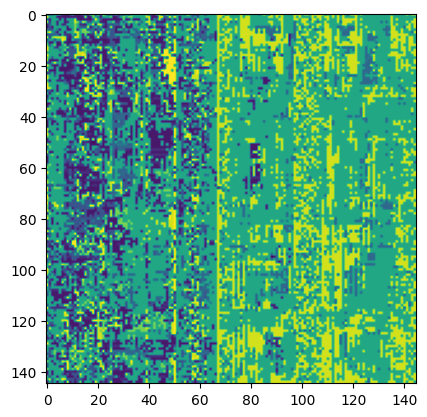

In [548]:
shape = int(np.sqrt(len(predicted_label1)))
plt.imshow(predicted_label1.reshape(shape, shape))

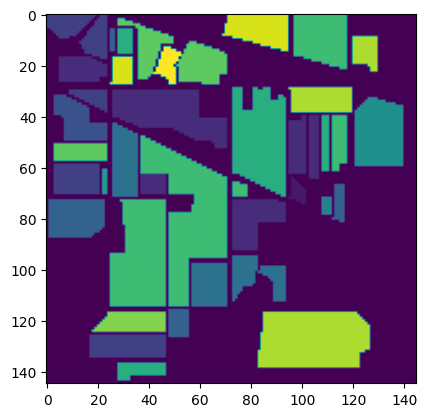

In [527]:
shape = int(np.sqrt(len(y)))
plt.imshow(y.reshape(shape, shape))